# German Bank Credit Risk Prediction

### Import the libraries

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical testing 
from scipy.stats import mannwhitneyu

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# set theme of visualizations
sns.set_theme(style='whitegrid')
# display all columns
pd.set_option('display.max_columns', None)

### Import the Data

In [2]:
# Import data
data = pd.read_csv("GermanCredit.csv")
# drop unnecessary column
data = data.drop(columns=['Unnamed: 0'])
data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job,gender
0,-43.0,6,critical,radio/tv,1169,NaN,13 years,4,single,none,6 years,real estate,67,none,own,2,0,1,2.349340e+09,yes,skilled employee,male
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,NaN,none,5 months,real estate,22,none,own,1,1,1,NaN,yes,skilled employee,female
2,NaN,12,critical,education,2096,24.0,5 years,2,single,none,4 years,real estate,49,none,own,1,0,2,NaN,yes,unskilled resident,male
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,13 years,building society savings,45,none,for free,1,0,2,NaN,yes,skilled employee,male
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,13 years,unknown/none,53,none,for free,2,1,2,NaN,yes,skilled employee,male


In [3]:
# copy dataset
credit = data.copy()

In [4]:
# shape of data
credit.shape

(1000, 22)

In [5]:
# dataset general information
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   checking_balance      606 non-null    float64
 1   months_loan_duration  1000 non-null   int64  
 2   credit_history        1000 non-null   object 
 3   purpose               1000 non-null   object 
 4   amount                1000 non-null   int64  
 5   savings_balance       817 non-null    float64
 6   employment_length     938 non-null    object 
 7   installment_rate      1000 non-null   int64  
 8   personal_status       690 non-null    object 
 9   other_debtors         1000 non-null   object 
 10  residence_history     870 non-null    object 
 11  property              1000 non-null   object 
 12  age                   1000 non-null   int64  
 13  installment_plan      1000 non-null   object 
 14  housing               1000 non-null   object 
 15  existing_credits      

In [6]:
# look at the descriptive statistics
credit.drop(columns=['installment_rate', 'default']).describe().T

,count,mean,std,min,25%,50%,75%,max
checking_balance,606.0,9.724587e+01,2.069236e+02,-5.000000e+01,-2.300000e+01,2.400000e+01,1.317500e+02,9.990000e+02
months_loan_duration,1000.0,2.090300e+01,1.205881e+01,4.000000e+00,1.200000e+01,1.800000e+01,2.400000e+01,7.200000e+01
amount,1000.0,3.271258e+03,2.822737e+03,2.500000e+02,1.365500e+03,2.319500e+03,3.972250e+03,1.842400e+04
savings_balance,817.0,7.815704e+02,3.016984e+03,0.000000e+00,3.100000e+01,6.400000e+01,1.280000e+02,1.997200e+04
age,1000.0,3.554600e+01,1.137547e+01,1.900000e+01,2.700000e+01,3.300000e+01,4.200000e+01,7.500000e+01
existing_credits,1000.0,1.407000e+00,5.776545e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
dependents,1000.0,1.155000e+00,3.620858e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
telephone,404.0,2.344914e+09,3.008193e+06,2.340000e+09,2.342211e+09,2.344804e+09,2.347731e+09,2.349994e+09


Some Points to note:
1. At least, 25% of all customers had an overdraft in their checking balance
2. Customers were able to borrow for 4 months and even up to 6 years
3. At least, 75% of the customers borrowed less than 4000 Euros
4. Some have nothing in their savings acount and amlost all customers (at least 75%) had less than 129 Euros in their savings account
5. The customers had an average age of around 35-36 years with the youngest being 19 years and the oldest, 75 years
6. At least 50% of the customers have just 1 existing credit
7. At least, 75% of them have just one dependent
8. Telephone numbers were also collected as a mean of communication.
9. 'checking_balance', 'savings_balance', and 'telephone', all have missing values 

### Look at missing data and duplicate values

In [7]:
# Look at amount of missing values
credit.isnull().sum()

checking_balance        394
months_loan_duration      0
credit_history            0
purpose                   0
amount                    0
savings_balance         183
employment_length        62
installment_rate          0
personal_status         310
other_debtors             0
residence_history       130
property                  0
age                       0
installment_plan          0
housing                   0
existing_credits          0
default                   0
dependents                0
telephone               596
foreign_worker            0
job                       0
gender                    0
dtype: int64

In [8]:
# Duplicate values?
credit.duplicated().sum()

np.int64(0)

* No duplicate was found
* 6 columns have missing data, namely:
    checking_balance, savings_balance, employment_length, personal_status, residence_history and telephone

### Address data quality issues

In [9]:
# Some variables are meant to be numerical
# An Example; employment_length
# check the unique values
credit['employment_length'].unique()

array(['13 years', '2 years', '5 years', '3 years', '11 years', '4 years',
       nan, '6 months', '5 months', '16 years', '1 years', '17 years',
       '3 months', '9 years', '4 months', '10 years', '10 months',
       '1 months', '7 months', '19 years', '7 years', '14 years',
       '18 years', '0 months', '15 years', '9 months', '6 years',
       '8 years', '12 years', '11 months', '2 months', '8 months'],
      dtype=object)

In [10]:
# convert all values in employment_length into motnhs
# extract numbers and their units from the string
extracted = credit['employment_length'].str.split(' ', expand=True)
# map units to multipliers
extracted[1].map({'years':12, 'months':1})
# convert the years into months by multiplying the numeric values by the correct unit
credit['employment_length_in_months'] = extracted[0].astype(float) * extracted[1].map({'years':12, 'months':1})
credit = credit.drop(columns=['employment_length'])

In [11]:
# Do the same for residence_history
# extract numbers and their units from the string
extracted = credit['residence_history'].str.split(' ', expand=True)
# map units to multipliers
extracted[1].map({'years':12, 'months':1})
# convert the years into months by multiplying the numeric values by the correct unit
credit['residence_history_in_months'] = extracted[0].astype(float) * extracted[1].map({'years':12, 'months':1})
#credit[['residence_history', 'residence_history_in_months']]
credit = credit.drop(columns=['residence_history'])

In [12]:
## create flags for checking_balance and savings_balance, where 1 = missing and 0 = Not missing
credit['checking_balance_flag'] = credit['checking_balance'].isna().astype(int)
credit['savings_balance_flag'] = credit['savings_balance'].isna().astype(int)

## Then we fill those missing values with zero
#credit[['checking_balance', 'savings_balance']] = credit[['checking_balance', 'savings_balance']].fillna(0)

# Fill missing personal_status with unknown
credit['personal_status'] = credit['personal_status'].fillna('Unknown')

# Create a flag for column 'telephone' to show whether telephone was recorded and where it's not
# 0 stands for 'recorded', 1 stands for 'not recorded'
credit['telephone_recorded'] = credit['telephone'].isna().astype(int)
# drop 'telephone' column
credit = credit.drop(columns=['telephone'])

# create flag for both employment_length and residence_history in months
credit[['employment_length_flag', 'residence_history_flag']] = credit[[
                        'employment_length_in_months', 'residence_history_in_months']].isna().astype(int)

# where job contains 'unemployed' and the employment_length is null, impute with zero
credit.loc[credit['job'].str.contains('unemployed', case=False) & credit['employment_length_in_months'].isna(),
                            'employment_length_in_months'] = 0

# Fill other missing values with the median
credit['employment_length_in_months'] = credit['employment_length_in_months'].fillna(credit['employment_length_in_months'].median())

# Fill missing resident_history with the median also
credit['residence_history_in_months'] = credit['residence_history_in_months'].fillna(credit['residence_history_in_months'].median())

In addressing data quality issues;
* I changed all values in employment_length and residence_history into months and then removed the strings, to create new columns: employment_length_in_months and residence_history_in_months
* I dropped these two columns mentioned above
* I created a flag for missing values 
* At first, I filled the missing checking_balance and savings_balance with zero and then tried with median, and that unfortunately pulls the mean towards the imputted number. This signifies that the data is Missing Not At Random (MNAR). So, I left it blank for now.
* Dropped the 'telephone' column in favour of a new column that shows if telephone was recorded for that customer or not
* Where the job contains unemployed and the employment_length_in_months is null, I imputted with zero and filled other missing values in the column with the median
* Also, filled the missing residence_history_in_months with median. This imputation didn't affect the overall distribution of the two last mentioned columns.
* I filled missing personal status with unknown

### Create a checkpoint

In [13]:
first_credit = credit.copy()

## Exploratory Data Analysis (EDA)

### Univariate Analysis

default
0    0.7
1    0.3
Name: proportion, dtype: float64


Text(0, 0.5, 'Proportion')

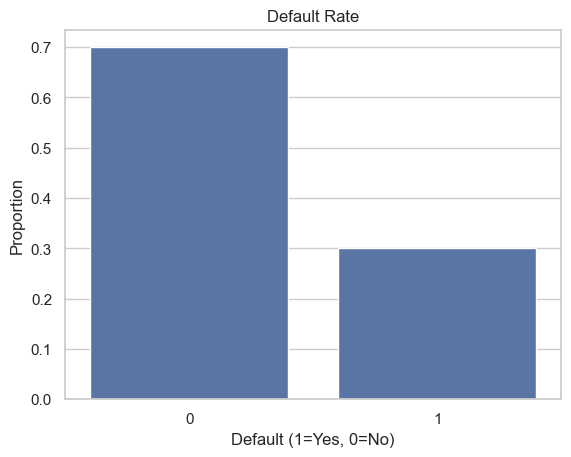

In [14]:
## Target Variable
proportion = first_credit['default'].value_counts(normalize=True)
print(proportion)
sns.barplot(proportion)
plt.title('Default Rate')
plt.xlabel('Default (1=Yes, 0=No)')
plt.ylabel('Proportion')


* About 30% of the customers defaulted, meanings there is a 30% default rate
* This also shows that there is class imbalance which must be taken into note during modelling

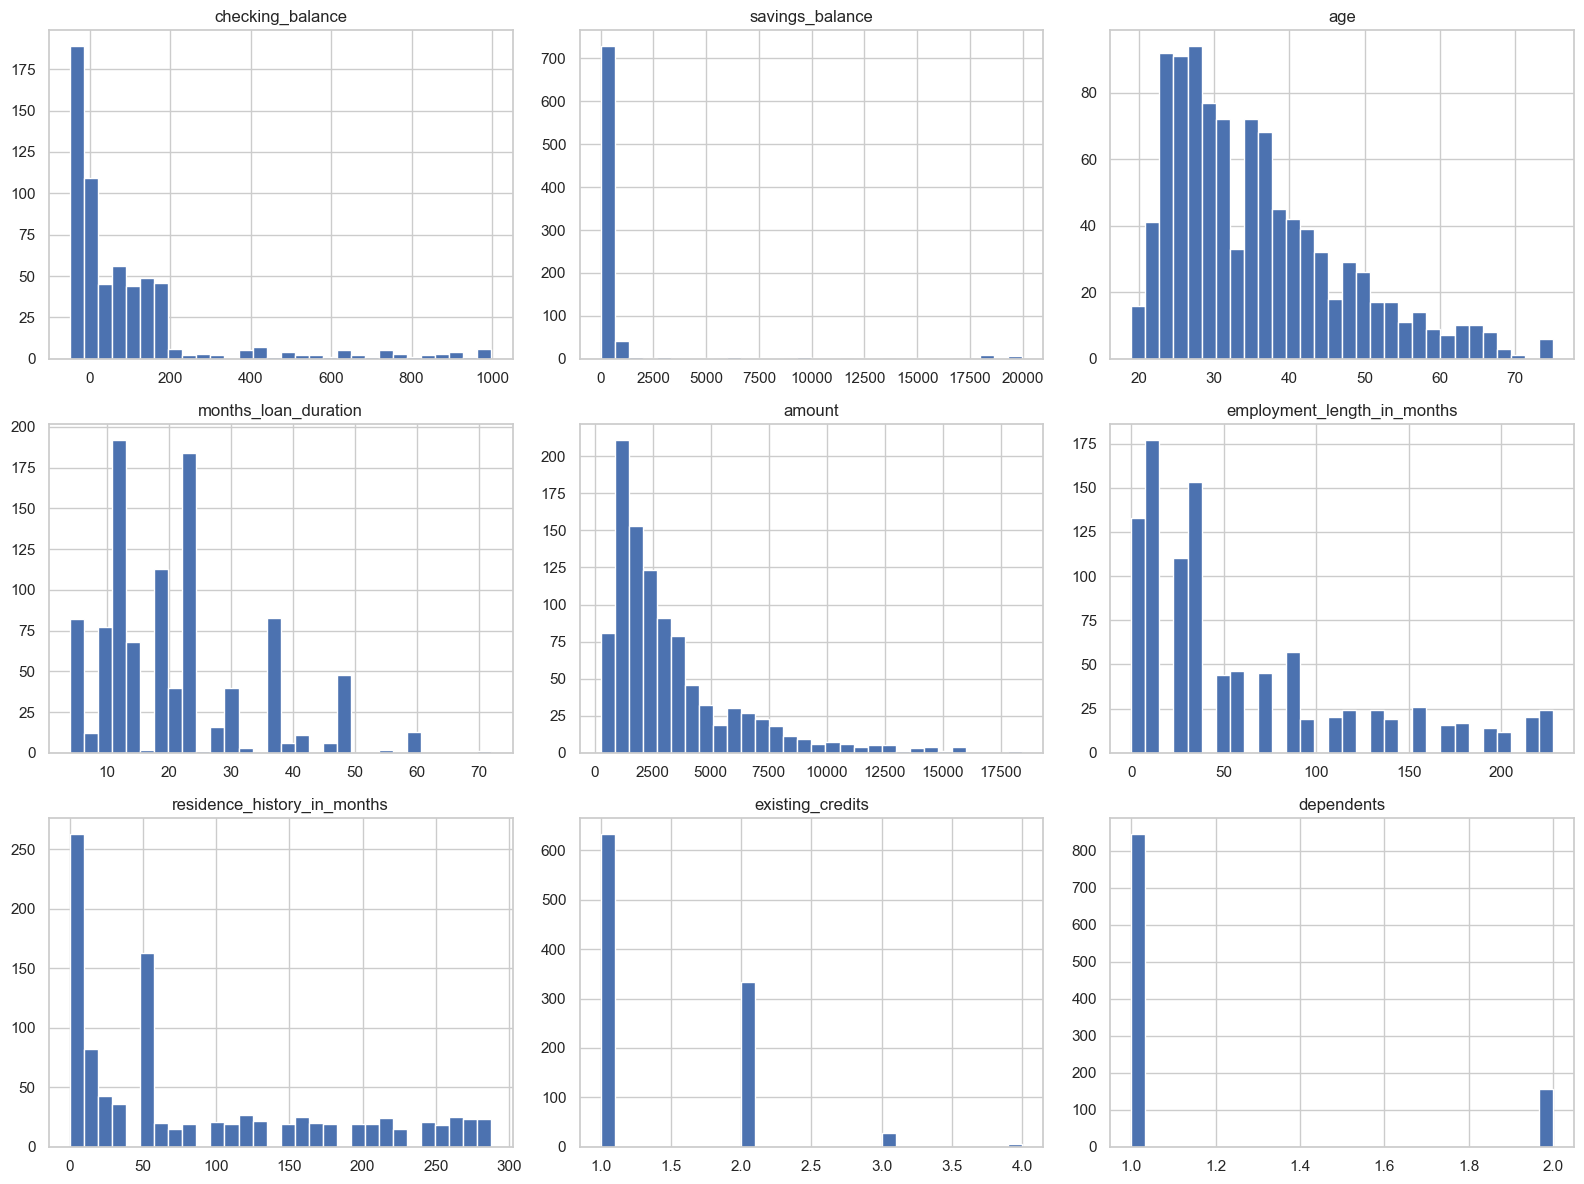

In [15]:
## Distributions of numerical variables

# Define the numerical variables
num_cols = ['checking_balance', 'savings_balance', 'age', 'months_loan_duration', 'amount',
    'employment_length_in_months', 'residence_history_in_months', 'existing_credits', 'dependents'
]

# Plot histograms to show distribution of all numerical columns
first_credit[num_cols].hist(figsize=(16,12), bins=30)
plt.tight_layout()
plt.show()

* All variabes are skewed to the left
* Most customers had checking balance ranging from Negative to 200 Euros and savings balance of less than 2500 Euros
* Majority are young customers within the ages of 24 and 35
* Amount showed an exponential distribution of majority of the customers applying for less than 2500, for 2 years and below
* Most customers might not be employed or have been employed for less than 4 years

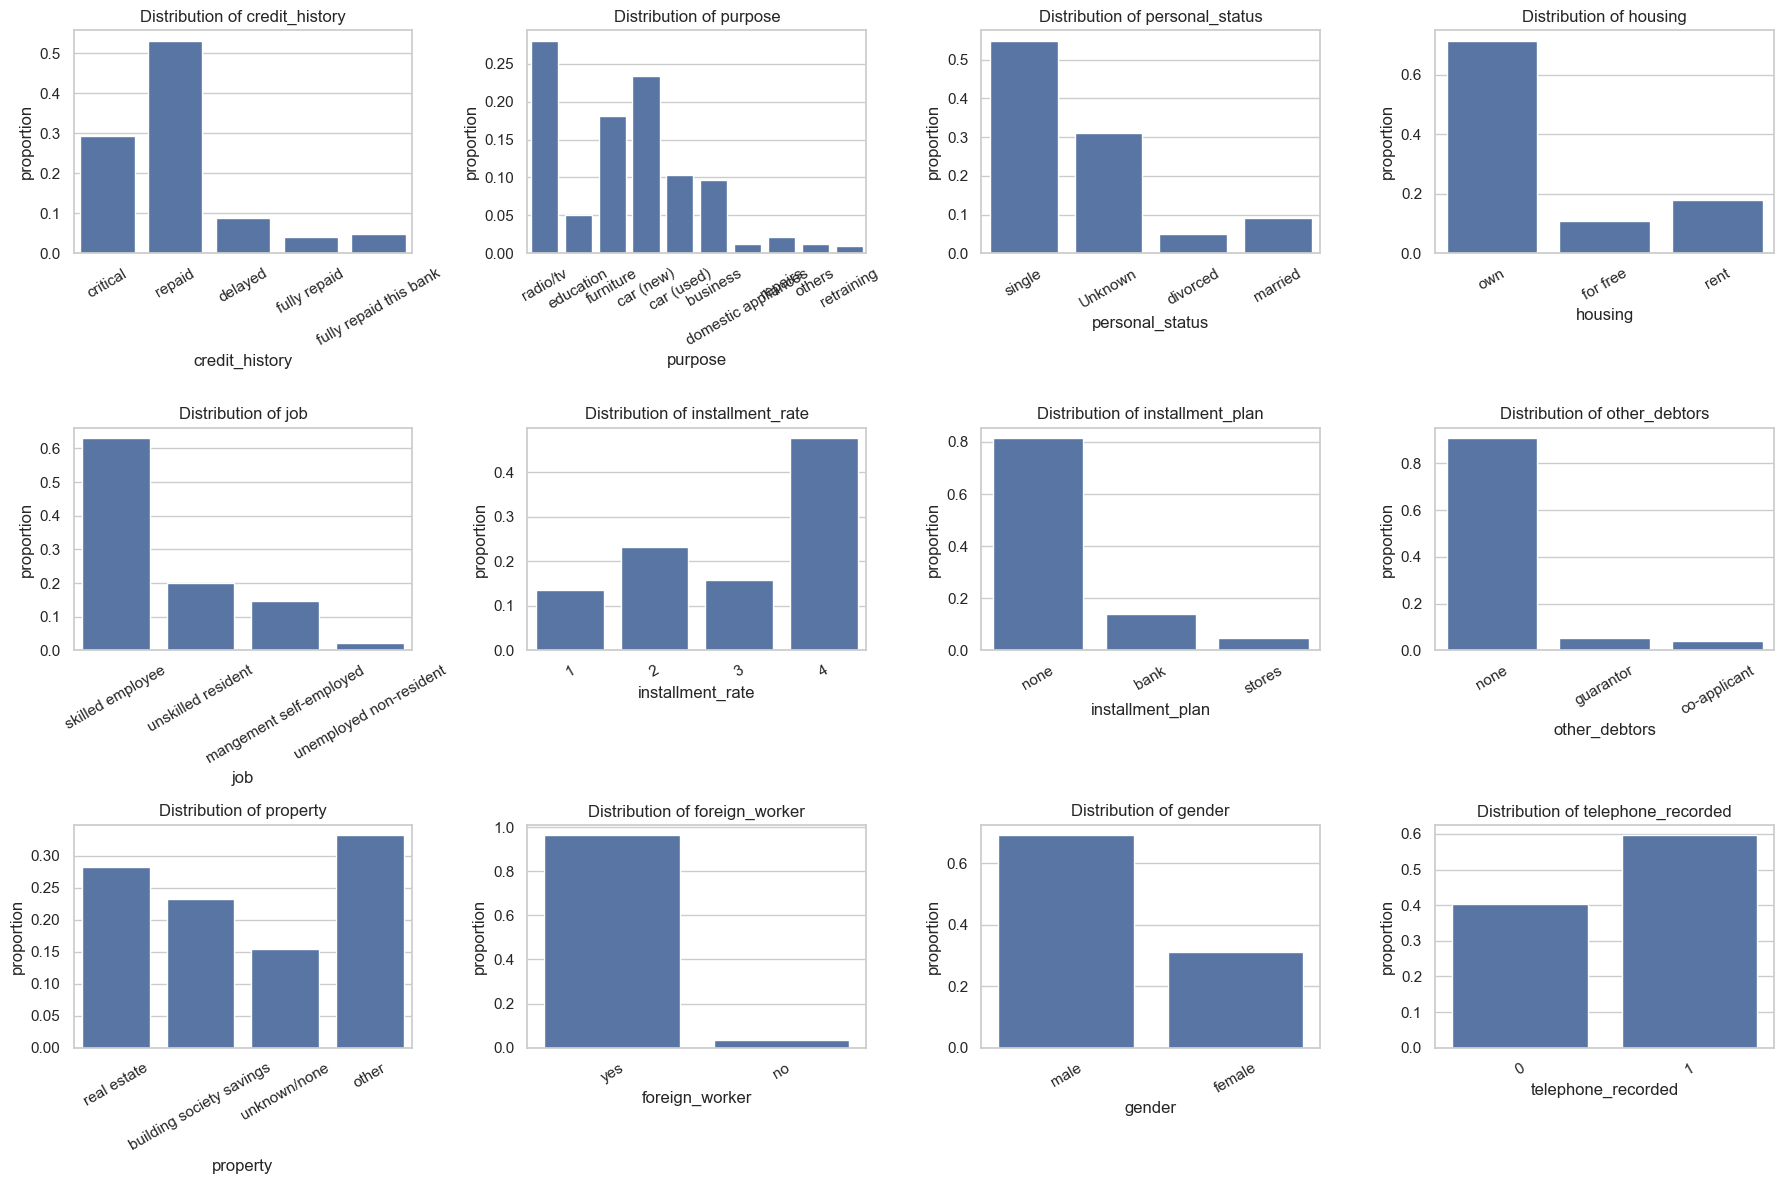

In [16]:
# Define Categorical columns
cat_cols = ['credit_history', 'purpose', 'personal_status', 'housing', 'job', 'installment_rate',
            'installment_plan', 'other_debtors', 'property', 'foreign_worker', 'gender', 'telephone_recorded'
            ]

# Define axes
n_rows, n_cols = 3, 4
n_plots = len(cat_cols)

# create the figure and a grid of axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,12))

# flatten axes
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(x=col, data=first_credit, ax=ax, stat='proportion')
    ax.set_title(f'Distribution of {col}')
    ax.tick_params(axis='x', rotation=30)
    
plt.tight_layout()
plt.show();

* For Credit history, more than 50% have repaid their loans
* Most of the customers were loaning for radio/tv (28%), Car(new) (23%), and for Furniture (18%)
* Most customers are single, followed by those whose marital status is unknown.
* More than 60% of the customers own their own house, while other are renting or are living there freely
* More than 60% of the customers are skilled employees, with only a small percent being unemployed
* About 80% have no installment plan, and among the 20% with installment plan, more than 40% chose installment rate of 4.
* Also, more than 80% of the customers are lone borrowers, i.e., they are not co-applying with anyone or serving as a guarantor for anybody.
* About 33% of the customers had properties labelled as other, about 27% had real estate, about 23% has buildong society savings and the rest have no or unknown properties.
* More than 90% are foreign workers, More than 60% are male customers and only about 40% of the customers has their telephone recorded. 

### Bivariate Analysis

In [17]:
# What effect does each numerical factor have on the default?
first_credit.groupby('default')[num_cols].mean().T

default,0,1
checking_balance,123.167614,61.322835
savings_balance,986.612022,361.541045
age,36.224286,33.963333
months_loan_duration,19.207143,24.860000
amount,2985.457143,3938.126667
employment_length_in_months,64.347143,53.120000
residence_history_in_months,85.625714,83.640000
existing_credits,1.424286,1.366667
dependents,1.155714,1.153333


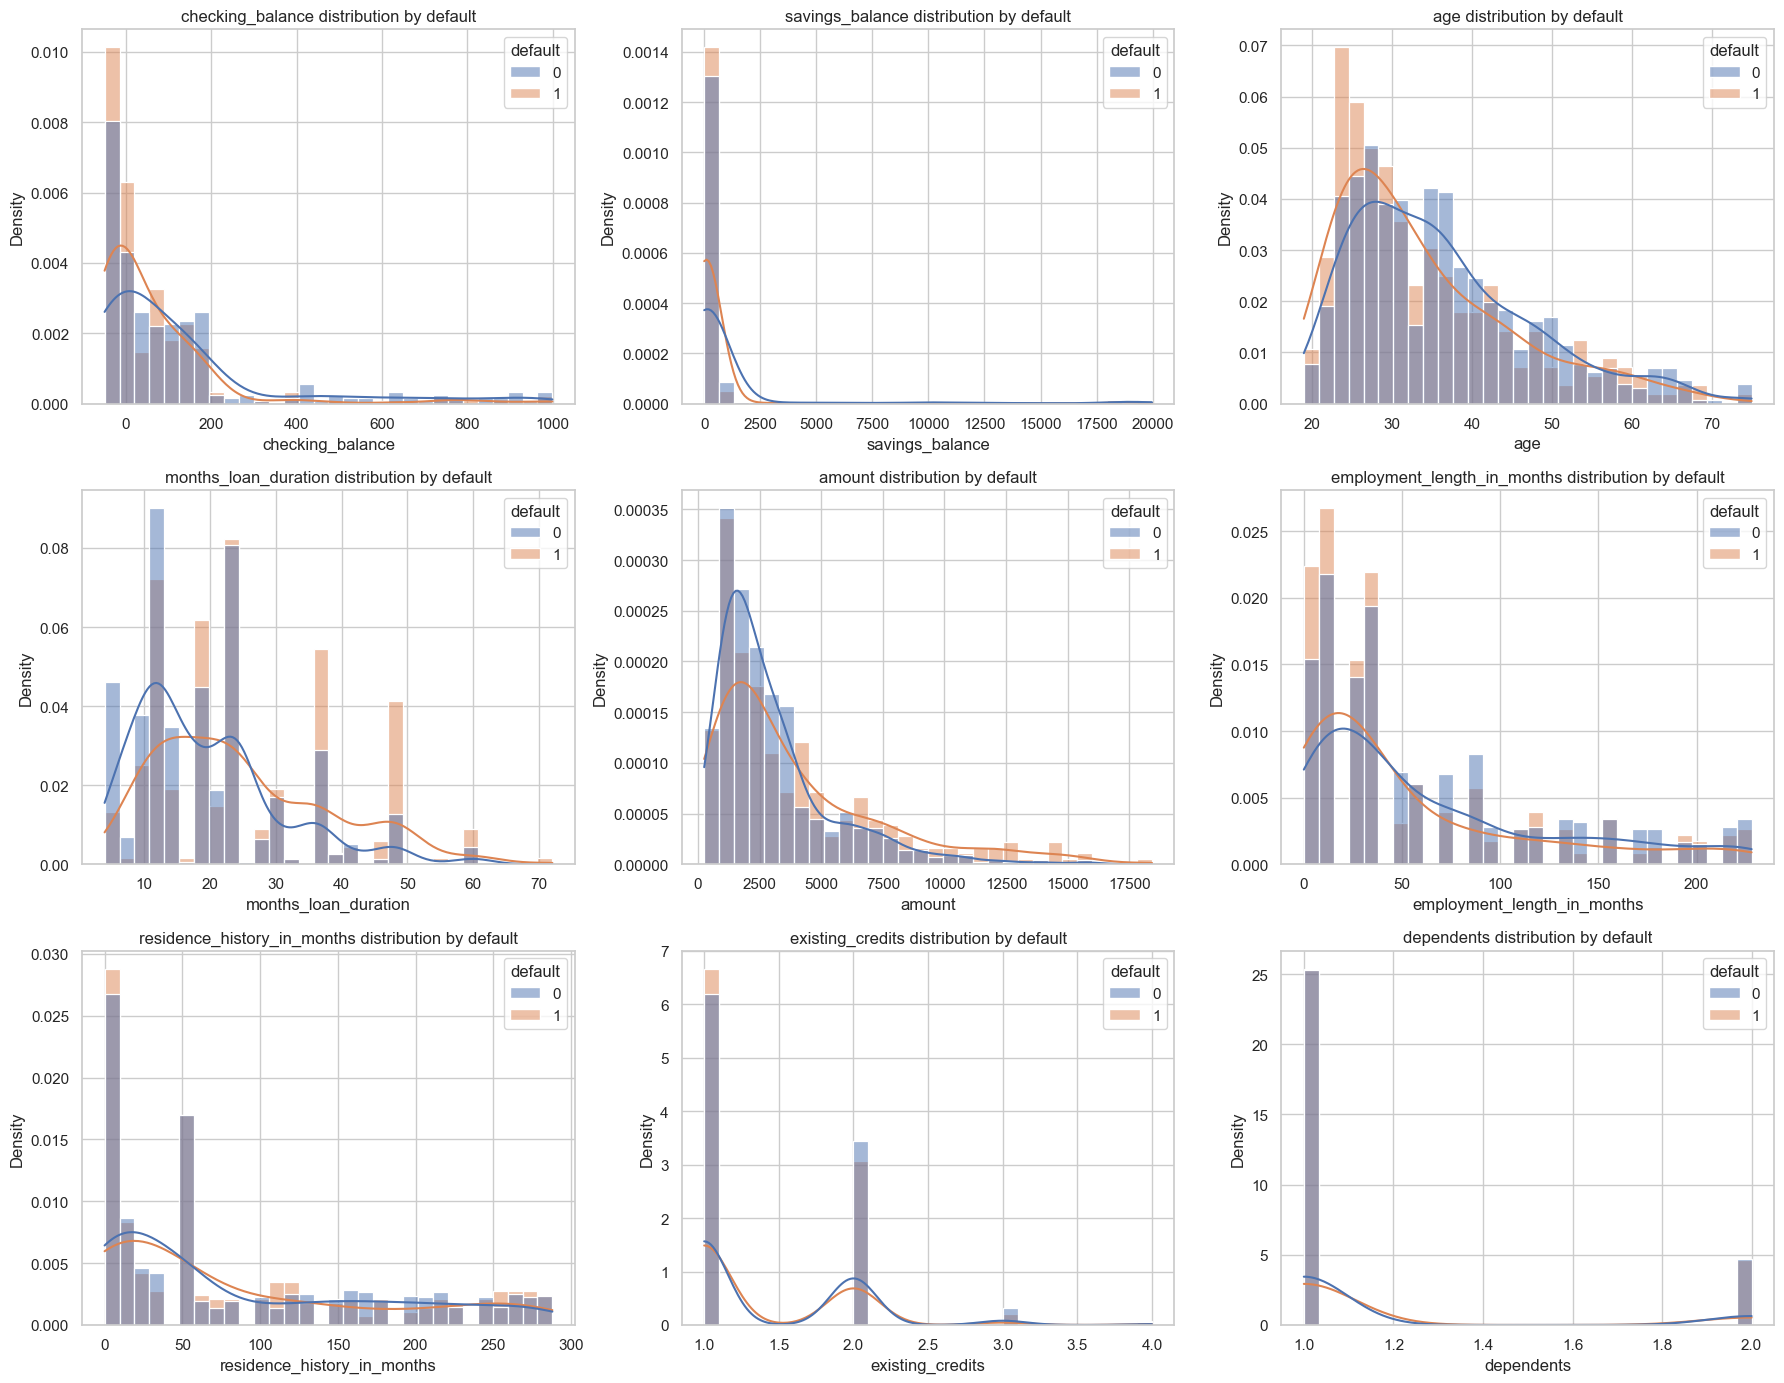

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

for i, var in enumerate(num_cols):
    sns.histplot(
        data=first_credit, x=var, hue='default', bins=30, kde=True, stat='density', common_norm=False,
        ax=axes[i])
    axes[i].set_title(f'{var} distribution by default')

# Remove empty subplots
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

* For each numerical variable, I checked the average of each risk factor for the default variable and;
    * Mean checking and savings balance for those who defaulted is much lower than those who didn't.
    * There is just a difference of approximately 3 years in the average years of those who didn't default and those who did
    * The average number of months for which the loan was taken and the average amount borrowed is higher for those who defaulted 
    * Average months since employment is lower for those who defaulted and average residence history has just a difference of 3 months
    * There doesn't seem to be a difference in the average existing credits and average number of dependents in those who defaulted and those who didn't.

* These results are also evident in the visualizations, for example, histogram fr amount loaned where we can see that those people who defaulted are shown to borrow higher amounts than those who didn't default.

* To further conclude on our results, I will statistically test if difference in the mean of those who defeaulted and those who didn't. 
* Also, I will categorize these variables to further visualizse their effect of the default rate

In [19]:
results = []

for col in num_cols:
    group_default = first_credit[first_credit['default'] == 1][col].dropna()
    group_nondefault = first_credit[first_credit['default'] == 0][col].dropna()
    
    # Mann–Whitney U test (two-sided)
    stat, p_value = mannwhitneyu(
        group_default,
        group_nondefault,
        alternative='two-sided'
    )
    
    results.append({
        'variable': col,
        'mean_default': group_default.mean(),
        'mean_nondefault': group_nondefault.mean(),
        'median_default': group_default.median(),
        'median_nondefault': group_nondefault.median(),
        'U_statistic': stat,
        'p_value': p_value
    })

results_df = pd.DataFrame(results)


In [20]:
results_df

,variable,mean_default,mean_nondefault,median_default,median_nondefault,U_statistic,p_value
0,checking_balance,61.322835,123.167614,-2.0,42.0,37088.0,3.421288e-04
1,savings_balance,361.541045,986.612022,53.5,70.0,62725.5,6.194102e-04
2,age,33.963333,36.224286,31.0,34.0,90167.0,3.912774e-04
3,months_loan_duration,24.860000,19.207143,24.0,18.0,132004.5,7.981666e-11
4,amount,3938.126667,2985.457143,2574.5,2244.0,116520.0,5.917609e-03
5,employment_length_in_months,53.120000,64.347143,36.0,36.0,90746.0,6.305502e-04
6,residence_history_in_months,83.640000,85.625714,48.0,48.0,102424.5,5.373951e-01
7,existing_credits,1.366667,1.424286,1.0,1.0,99728.0,1.348189e-01
8,dependents,1.153333,1.155714,1.0,1.0,104750.0,9.242356e-01


There is a statistically significant difference in the distribution of checking balance, savings balance, age, loan duration, amount, and employment length in months, between defaulters and non-defaulters

C:\Users\USER\AppData\Local\Temp\ipykernel_32792\3018542391.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('checking_bin')['default'].mean().plot(kind='bar')


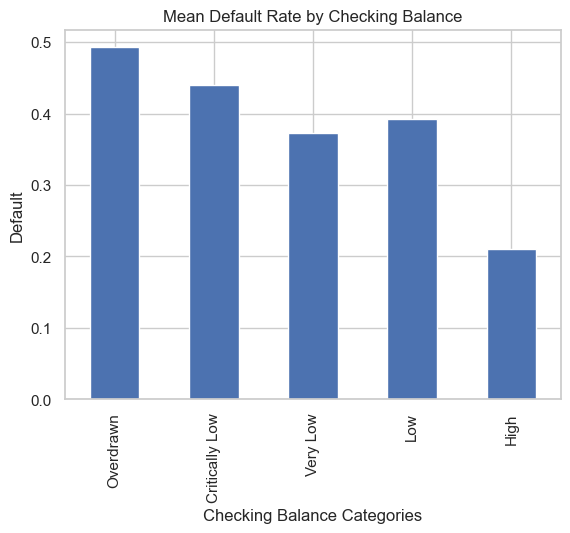

In [21]:
first_credit['checking_bin'] = pd.cut(
                                first_credit['checking_balance'],
                                bins=[-100, -1, 20, 67, 250, 1000],
                                labels=['Overdrawn', 'Critically Low', 'Very Low', 'Low', 'High']
)

plt.figure()
first_credit.groupby('checking_bin')['default'].mean().plot(kind='bar')
plt.title("Mean Default Rate by Checking Balance")
plt.xlabel("Checking Balance Categories")
plt.ylabel("Default")
plt.show();

* Here we can also see, that, the more money there is, in a customer's checking account, the less likely they are, to default

C:\Users\USER\AppData\Local\Temp\ipykernel_32792\1096328376.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('savings_bin')['default'].mean().plot(kind='bar')


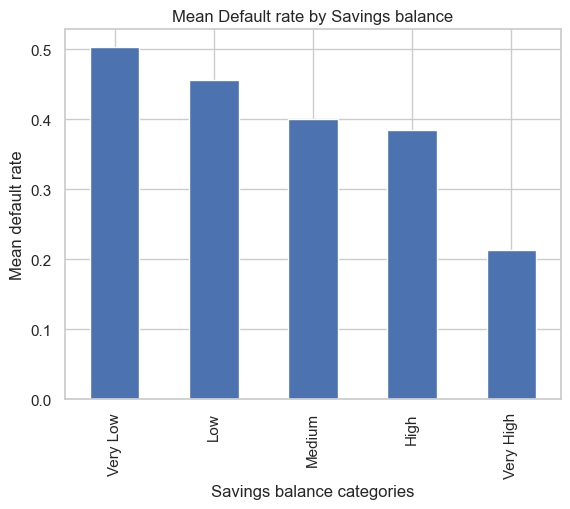

In [22]:
first_credit['savings_bin'] = pd.qcut(
                                first_credit['checking_balance'],
                                q=[0, 0.25, 0.5, 0.75, 0.9, 1.0],
                                labels=['Very Low' ,'Low', 'Medium', 'High', 'Very High']
)
plt.figure()
first_credit.groupby('savings_bin')['default'].mean().plot(kind='bar')
plt.title("Mean Default rate by Savings balance")
plt.xlabel('Savings balance categories')
plt.ylabel("Mean default rate")
plt.show();

* This also confirms, that the more the money in a brrower's savings account, the less likely they are to default

C:\Users\USER\AppData\Local\Temp\ipykernel_32792\3176671602.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('age_bin')['default'].mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_32792\3176671602.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('age_bin')['default'].mean().plot(kind='bar')


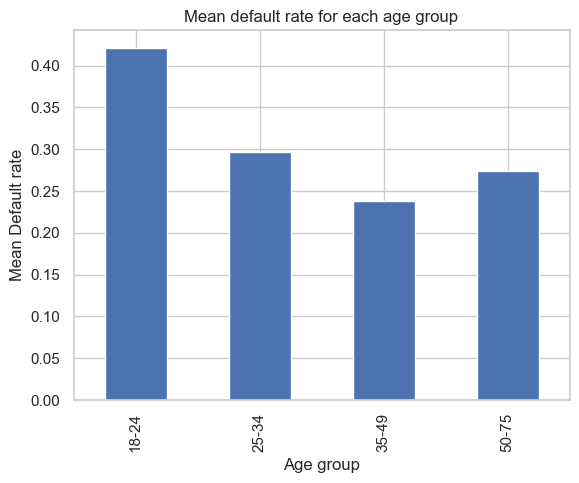

In [23]:
bins = [18, 25, 35, 50, 75]
labels = ['18-24', '25-34', '35-49', '50-75']
first_credit['age_bin'] = pd.cut(first_credit['age'], bins=bins, labels=labels)

first_credit.groupby('age_bin')['default'].mean()
plt.figure()
first_credit.groupby('age_bin')['default'].mean().plot(kind='bar')
plt.title("Mean default rate for each age group")
plt.xlabel('Age group')
plt.ylabel("Mean Default rate")
plt.show();

* The default rate is particularly high for young people

C:\Users\USER\AppData\Local\Temp\ipykernel_32792\4089055644.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('loan_duration_bin')['default'].mean().plot()


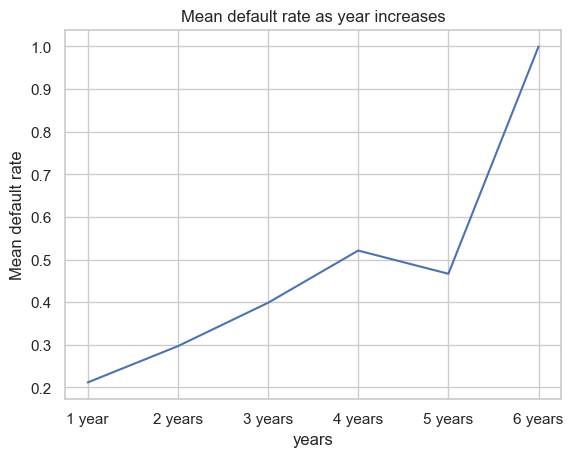

In [24]:
bins = [0, 12, 25, 37, 49, 61, 72]
labels = ['1 year', '2 years', '3 years', '4 years', '5 years', '6 years']
first_credit['loan_duration_bin'] = pd.cut(first_credit['months_loan_duration'], bins=bins, labels=labels)

plt.figure()
first_credit.groupby('loan_duration_bin')['default'].mean().plot()
plt.title('Mean default rate as year increases')
plt.xlabel('years')
plt.ylabel('Mean default rate')
plt.show();

* THis also shows tha the longer the duration a loan was taker, the more likely for that person

C:\Users\USER\AppData\Local\Temp\ipykernel_32792\4192020363.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_credit.groupby('amount_bin')['default'].mean().plot(kind='barh')


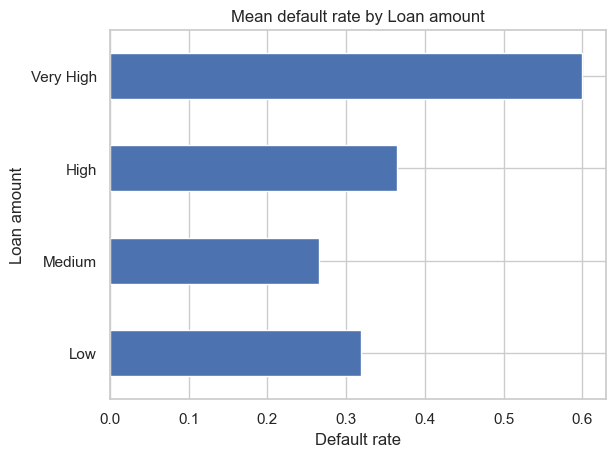

In [25]:
first_credit['amount_bin'] = pd.cut(
                                first_credit['amount'],
                                bins=[0, 1000, 5000, 10000, 20000],
                                labels=['Low', 'Medium', 'High', 'Very High']
)

plt.figure()
first_credit.groupby('amount_bin')['default'].mean().plot(kind='barh')
plt.title('Mean default rate by Loan amount')
plt.xlabel('Default rate')
plt.ylabel('Loan amount')
plt.show();

* The risk of defaulting is also high when someone borrows a large amount

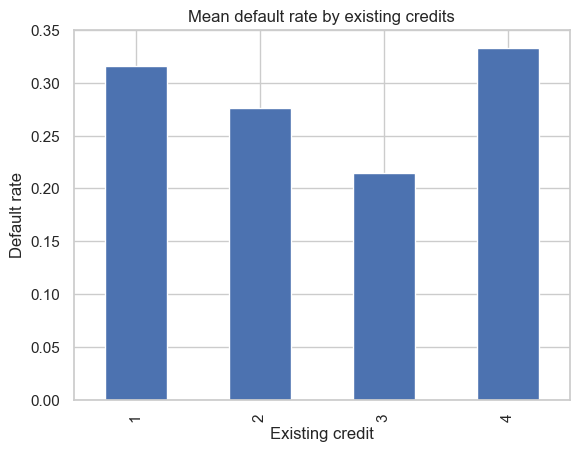

In [26]:
plt.figure()
first_credit.groupby('existing_credits')['default'].mean().plot(kind='bar')
plt.title('Mean default rate by existing credits')
plt.xlabel('Existing credit')
plt.ylabel('Default rate')
plt.show();

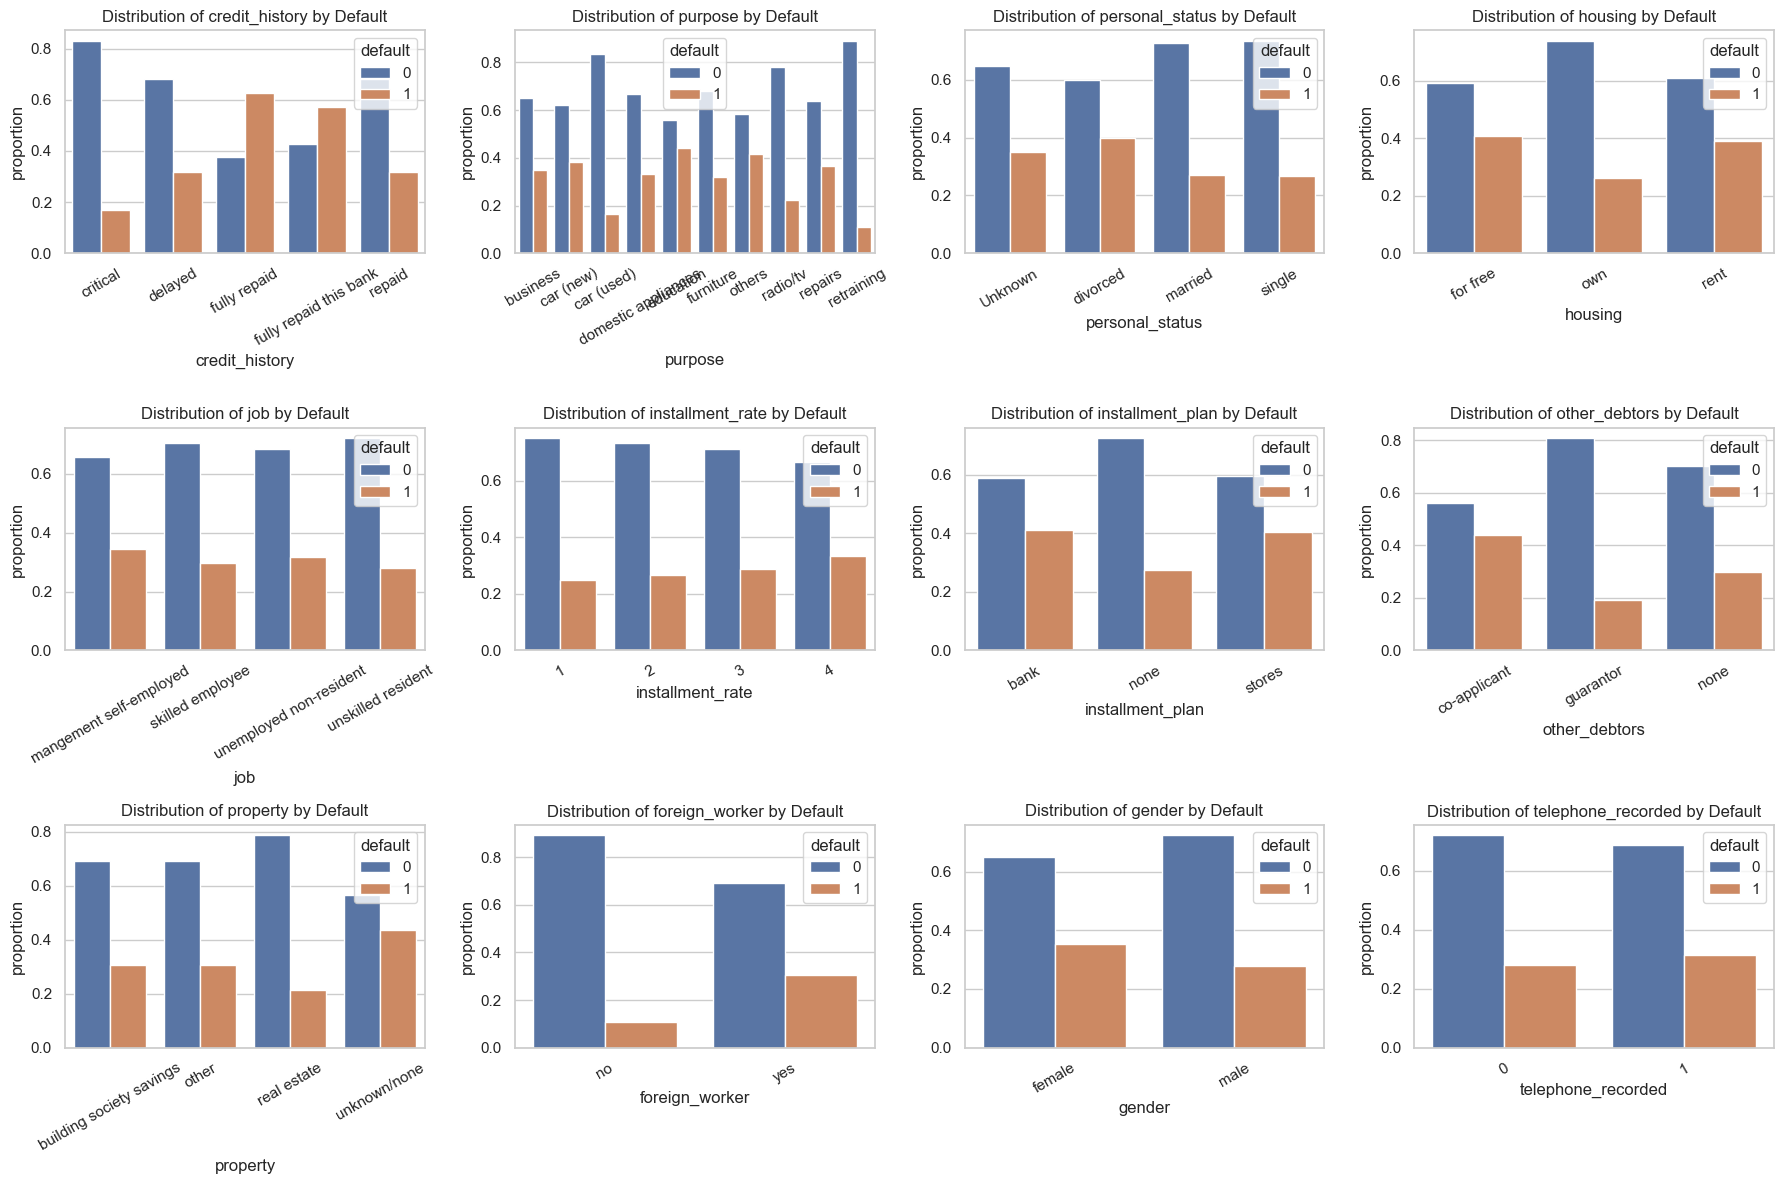

In [27]:
# Define axes
n_rows, n_cols = 3, 4
n_plots = len(cat_cols)

# create the figure and a grid of axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,12))

# flatten axes
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    prop_df = (first_credit.groupby(col)['default']
               .value_counts(normalize=True)
               .rename('proportion')
               .reset_index())
    
    sns.barplot(data=prop_df, x=col, y='proportion', hue='default', ax=ax)
    ax.set_title(f'Distribution of {col} by Default')
    ax.tick_params(axis='x', rotation=30)
    
plt.tight_layout()
plt.show();

* Categories like 'fully repaid' and 'fully repaid this bank' exhibit high default rates and customers with credit history tagged 'critical' have the lowest default rate.
* Loan purpose shows clear separation in default risk, as people who loan to buy cheap items or items that can be resold like furniture, radio/tv, used cars have a lower default risk. People who loan for business, education, to buy new car or for uncertain purposes, have a higher default risk.
* Divorced customers and those with unknown statuses have a higher default risk.
* Customers who have their own house (property), real estate, etc. have the lowest default risk. Others who rent or live somewhere for free (don't have a property) exhibit a higher default risk
* As the installment rate increases, there seems to be an increase in the default risk.
* External installment obligations increases risk
* The presence of guarantors significantly reduces the default risk.
* Being a foreign worker also increases the risk of defaulting

### Multivariate Analysis

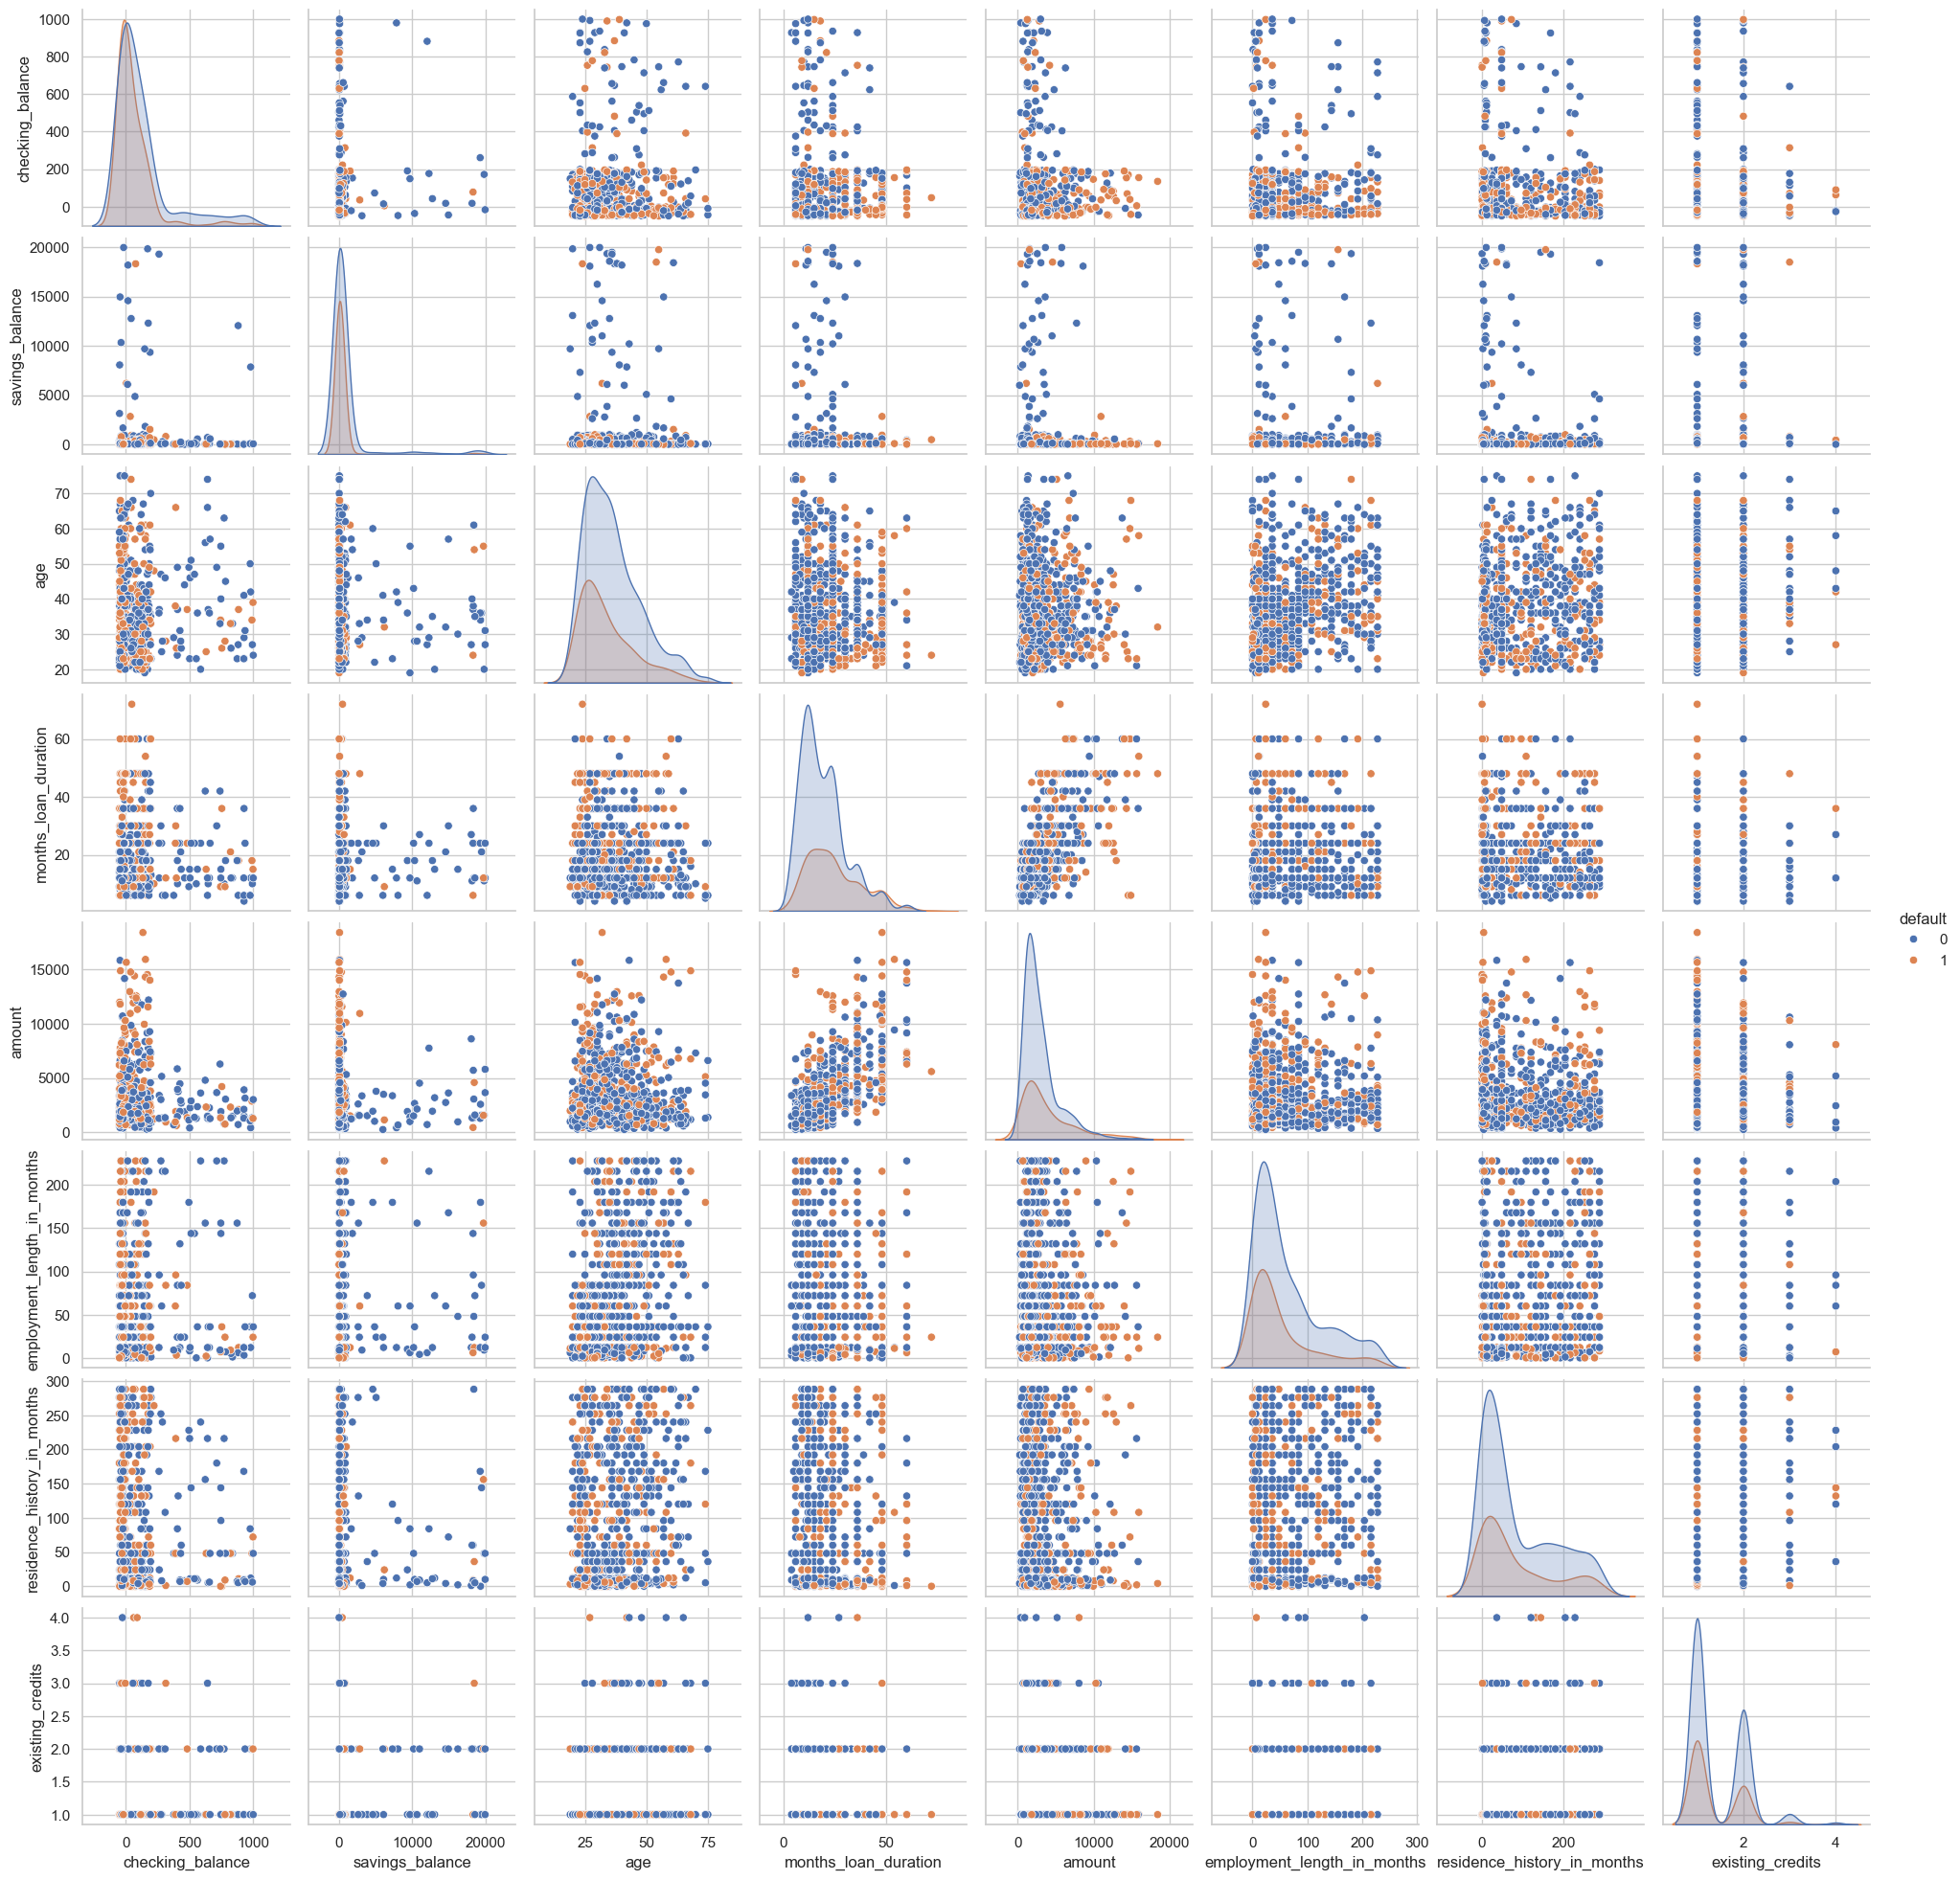

In [28]:
sns.pairplot(data=first_credit[['checking_balance', 'savings_balance', 'age', 'months_loan_duration', 'amount',
    'employment_length_in_months', 'residence_history_in_months', 'existing_credits', 'default']], hue='default')

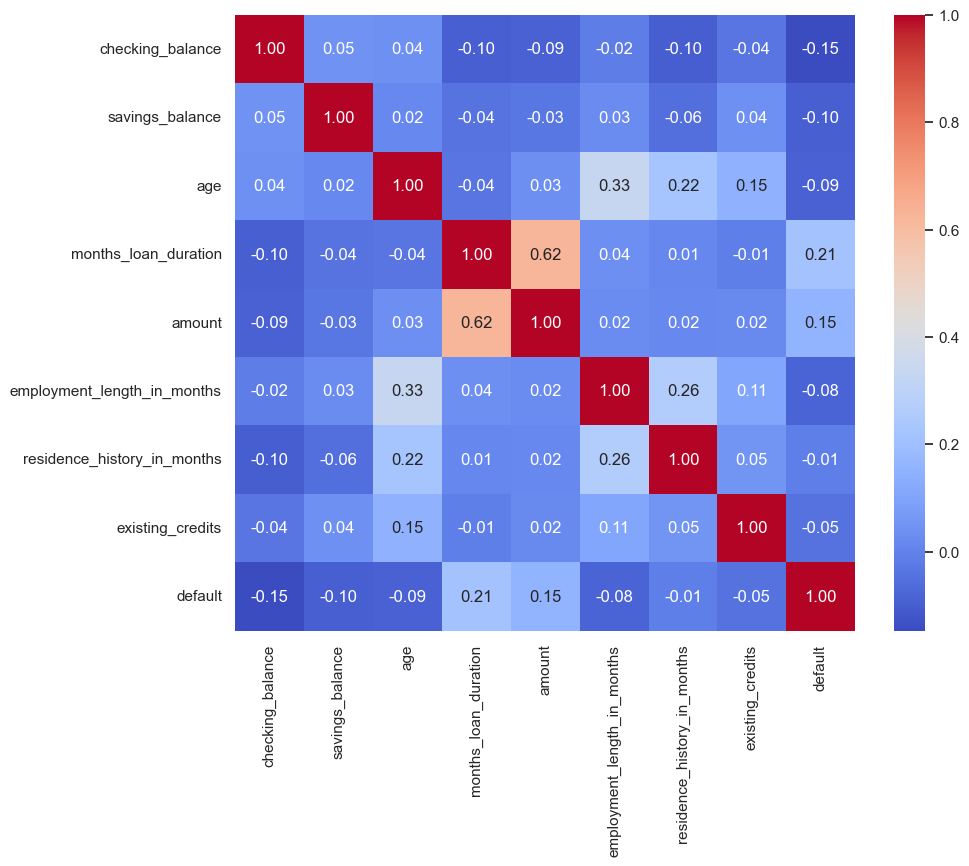

In [29]:
#check pearson correlation
plt.figure(figsize=(10,8))
sns.heatmap(first_credit[['checking_balance', 'savings_balance', 'age', 'months_loan_duration', 'amount',
    'employment_length_in_months', 'residence_history_in_months', 'existing_credits', 'default']].corr(), annot=True,
            fmt='.2f', cmap='coolwarm')
plt.show();

* There is a low multicollinearity. There is a relationship between the loan amount and loan duration

### Another Checkpoint

In [30]:
second_credit = credit.copy()

In [31]:
second_credit

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,installment_rate,personal_status,other_debtors,property,age,installment_plan,housing,existing_credits,default,dependents,foreign_worker,job,gender,employment_length_in_months,residence_history_in_months,checking_balance_flag,savings_balance_flag,telephone_recorded,employment_length_flag,residence_history_flag
0,-43.0,6,critical,radio/tv,1169,NaN,4,single,none,real estate,67,none,own,2,0,1,yes,skilled employee,male,156.0,72.0,0,1,0,0,0
1,75.0,48,repaid,radio/tv,5951,89.0,2,Unknown,none,real estate,22,none,own,1,1,1,yes,skilled employee,female,24.0,5.0,0,0,1,0,0
2,NaN,12,critical,education,2096,24.0,2,single,none,real estate,49,none,own,1,0,2,yes,unskilled resident,male,60.0,48.0,1,0,1,0,0
3,-32.0,42,repaid,furniture,7882,9.0,2,single,guarantor,building society savings,45,none,for free,1,0,2,yes,skilled employee,male,60.0,156.0,0,0,1,0,0
4,-23.0,24,delayed,car (new),4870,43.0,3,single,none,unknown/none,53,none,for free,2,1,2,yes,skilled employee,male,36.0,156.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,12,repaid,furniture,1736,48.0,3,Unknown,none,real estate,31,none,own,1,0,1,yes,unskilled resident,female,48.0,240.0,1,0,1,0,0
996,-30.0,30,repaid,car (used),3857,20.0,4,divorced,none,building society savings,40,none,own,1,0,1,yes,mangement self-employed,male,36.0,60.0,0,0,0,0,0
997,NaN,12,repaid,radio/tv,804,44.0,4,single,none,other,38,none,own,1,0,1,yes,skilled employee,male,156.0,192.0,1,0,1,0,0
998,-18.0,45,repaid,radio/tv,1845,31.0,4,single,none,unknown/none,23,none,for free,1,1,1,yes,skilled employee,male,24.0,96.0,0,0,0,0,0


### Modelling

In [32]:
# Split data
X = second_credit.drop(columns=['default'])
y = second_credit['default']

In [33]:
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [34]:
# select categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.to_list()
numerical_cols = X.select_dtypes(exclude='object').columns.to_list()

In [35]:
# Due to not filling the missing values in checking_balance and savings_balance above,
# I need to create a separate imputer for those two columns
# I also need to encode the categorical variables, so I create a separate transformer for that as well
balance_cols = ['checking_balance', 'savings_balance']
numeric_transformer = ColumnTransformer(transformers=[
    ('balance', SimpleImputer(strategy='constant', fill_value=0), balance_cols)
], remainder='passthrough')

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

* For a baseline, I'll train Decision Tree model.
* I chose a tree model because the data doesn't contain linear relationships, thta might be beneficial for linear models
* And after having my baseline, I will use ensemble methods to further improve the predictiong of defaulting

In [36]:
# Initialize the model
dt_model = DecisionTreeClassifier(
    max_depth=5, min_samples_leaf=50, class_weight={0: 1, 1: 2}, random_state=42
)

# Create a pipeline that combines the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', dt_model)
])

# Use StratifiedKFold for cross-validation to maintain class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation and calculate ROC-AUC scores
auc_scores = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='roc_auc')

print("CV ROC-AUC:", auc_scores)
print("Mean ROC-AUC:", auc_scores.mean())

CV ROC-AUC: [0.66639088 0.68777902 0.69810268 0.67010789 0.78357515]
Mean ROC-AUC: 0.7011911225638905


#### Random Forest Model

In [37]:
# Initialize the Random Forest model with specified hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=8, min_samples_leaf=30, class_weight='balanced', random_state=42, n_jobs=1
)

# Create a pipeline that combines the preprocessor and the Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(rf_pipeline, x_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)

print("CV ROC-AUC:", np.round(cv_auc, 3))
print("Mean ROC-AUC:", np.round(cv_auc.mean(), 3))

CV ROC-AUC: [0.721 0.77  0.783 0.701 0.829]
Mean ROC-AUC: 0.76


* I'll check the feature importance based on the random forest training

In [38]:
rf_pipeline.fit(x_train, y_train)

importances = rf_pipeline.named_steps['model'].feature_importances_
feature_names = rf_pipeline.named_steps['preprocess'].get_feature_names_out()

fi = (pd.DataFrame({'feature': feature_names,
                    'importance': importances}).sort_values('importance', ascending=False))

fi.head(20)

,feature,importance
10,num__remainder__checking_balance_flag,0.199284
0,num__balance__checking_balance,0.144092
2,num__remainder__months_loan_duration,0.083916
5,num__remainder__age,0.083176
3,num__remainder__amount,0.078608
15,cat__credit_history_critical,0.059995
1,num__balance__savings_balance,0.050430
8,num__remainder__employment_length_in_months,0.040675
45,cat__housing_own,0.033066
39,cat__property_real estate,0.026331


* The main features here are age, checking_balance_flag, checking balance, months_loan_duration, credit_history(critical), savings balance, existing credits, amount, employment length, residence_history, housing(own), telephone_recorded, etc.
* The importance shows that no feature was dominant. Several expected features based on the EDA contributed to prediction

#### XGBoost

In [39]:
scale_pos_weight = (second_credit['default'] == 0).sum() / (second_credit['default'] == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', xgb_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(xgb_pipeline, x_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)

print("CV ROC-AUC:", np.round(cv_auc, 3))
print("Mean ROC-AUC:", np.round(cv_auc.mean(), 3))

CV ROC-AUC: [0.73  0.755 0.806 0.702 0.834]
Mean ROC-AUC: 0.765


In [40]:
xgb_pipeline.fit(x_train, y_train)

importances = xgb_pipeline.named_steps['model'].feature_importances_
feature_names = xgb_pipeline.named_steps['preprocess'].get_feature_names_out()

fxgb = (pd.DataFrame({'feature': feature_names,
                    'importance': importances}).sort_values('importance', ascending=False))

fxgb.head(20)

,feature,importance
10,num__remainder__checking_balance_flag,0.092089
42,cat__installment_plan_none,0.033520
15,cat__credit_history_critical,0.031776
36,cat__other_debtors_none,0.028815
35,cat__other_debtors_guarantor,0.028161
40,cat__property_unknown/none,0.027399
17,cat__credit_history_fully repaid,0.023031
44,cat__housing_for free,0.022649
49,cat__job_mangement self-employed,0.022518
45,cat__housing_own,0.021403


* Becuase Random Forest gave the most satisfactory performance, I'll go ahead with using its prediction to score the customers (Credit Scoring)

In [41]:
# Join x_train and y_train together for analysis
x_train_with_y = x_train.copy()
x_train_with_y['default'] = y_train.values

In [42]:
# Check for predicted probabilities of default
x_train_with_y['p_default'] = rf_pipeline.predict_proba(x_train_with_y.drop('default', axis=1))[:, 1]
x_train_with_y.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,installment_rate,personal_status,other_debtors,property,age,installment_plan,housing,existing_credits,dependents,foreign_worker,job,gender,employment_length_in_months,residence_history_in_months,checking_balance_flag,savings_balance_flag,telephone_recorded,employment_length_flag,residence_history_flag,default,p_default
29,-2.0,60,delayed,business,6836,73.0,3,single,none,unknown/none,63,none,own,2,1,yes,skilled employee,male,120.0,120.0,0,0,0,0,0,1,0.648776
535,821.0,21,critical,education,2319,29.0,2,divorced,none,other,33,none,rent,1,1,yes,skilled employee,male,9.0,48.0,0,0,1,0,1,1,0.519375
695,NaN,6,repaid,car (used),1236,661.0,2,single,none,building society savings,50,none,rent,1,1,yes,skilled employee,male,36.0,156.0,1,0,1,0,0,0,0.297966
557,NaN,21,fully repaid,car (new),5003,NaN,1,Unknown,none,building society savings,29,bank,own,2,1,yes,skilled employee,female,36.0,96.0,1,1,0,0,0,1,0.472605
836,NaN,12,repaid,radio/tv,886,NaN,4,Unknown,none,other,21,none,own,1,1,yes,skilled employee,female,24.0,3.0,1,1,1,0,0,0,0.402820


In [43]:
# Calculate credit scores

# set my base score and PDO
base_score = 600
pdo = 20

# Compute the factor and offset for the credit score formula
factor = pdo / np.log(2)
offset = base_score - factor * np.log(1)

# Calculate credit scores using the formula: score = offset + factor * log((1 - p_default) / p_default)
x_train_with_y['credit_score'] = offset + factor * np.log((1 - x_train_with_y['p_default']) / x_train_with_y['p_default'])

In [44]:
x_train_with_y[['p_default', 'credit_score']].head(10)

,p_default,credit_score
29,0.648776,582.293414
535,0.519375,597.762730
695,0.297966,624.727891
557,0.472605,603.164962
836,0.402820,611.360626
596,0.714132,573.583147
165,0.292546,625.479480
918,0.592520,589.197323
495,0.606305,587.540635
824,0.315127,622.398014


* I will go ahead to calculate the Kolmogorov-Smirnov (KS) Statistic that shows the maximum distance between the cumulative distribution of defaulters and non-defaulters across the score range.

KS = 0 means no separation
KS = 1 means perfecr separation

In [46]:
import pandas as pd
import numpy as np

# Assume y_test = true labels, y_probs = predicted probabilities of default
df = pd.DataFrame({'y': x_train_with_y['default'], 'prob': x_train_with_y['p_default']})

# Sort by predicted probability descending
df = df.sort_values('prob', ascending=False)

# Compute cumulative distributions
df['cum_good'] = (df['y'] == 0).cumsum() / (df['y'] == 0).sum()
df['cum_bad'] = (df['y'] == 1).cumsum() / (df['y'] == 1).sum()

# KS statistic
df['ks'] = np.abs(df['cum_good'] - df['cum_bad'])
ks_value = df['ks'].max()
print(f"KS Statistic: {ks_value:.3f}")


KS Statistic: 0.511


* Based on the KS statistic of 0.511, 51.1% more bad customers are captured than good customers as risky.

* I will go ahead to visualize that using a density plot

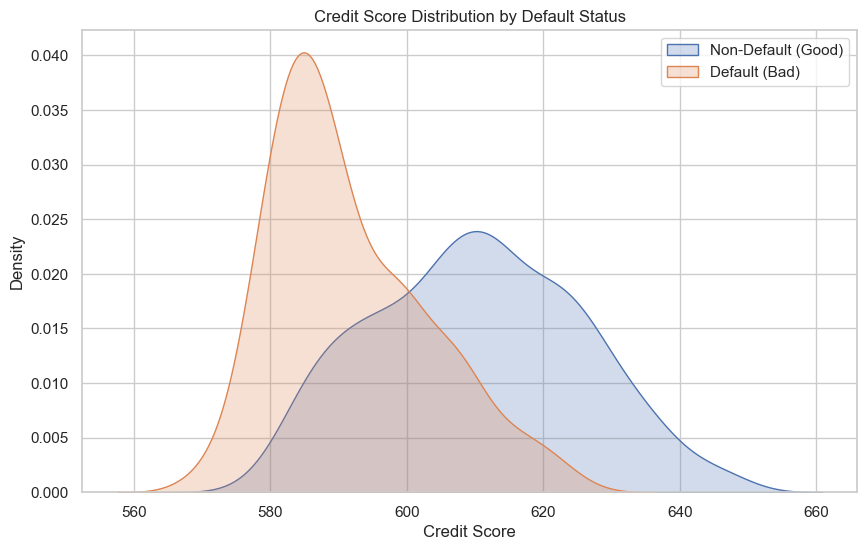

In [47]:
plt.figure(figsize=(10,6))
sns.kdeplot(x_train_with_y.loc[x_train_with_y['default'] == 0, 'credit_score'], label='Non-Default (Good)', fill=True)
sns.kdeplot(x_train_with_y.loc[x_train_with_y['default'] == 1, 'credit_score'], label='Default (Bad)', fill=True)

plt.title("Credit Score Distribution by Default Status")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.legend()
plt.show()


* The Credit score distribution shows that the model was able to clearly separate the defaulters
    * Defaulters are concentrated around lower credit scores (500-600)
    * Non-defaulters peak at a higher credit score (600-660)

* This shows that as credit score increases, probability of the person defaulting decreases